## Interactive subspaces

This notebook let you to gaze subspaces we learn with an interactive UMAP.

In [1]:
import json
import torch
import pandas as pd
import altair as alt
from umap import UMAP
from plotnine import *

In [2]:
def load_jsonl(filepath):
    """Example JSONL loading function."""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def get_genre(metadata_entry):
    """Returns the genre string ('text', 'code', or 'math')."""
    concept_name = metadata_entry['concept']
    return metadata_entry['concept_genres_map'][concept_name][0]

In [3]:
lsreft = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

diffmean = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/DiffMean_weight.pt")
diffmean_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/metadata.jsonl")
assert diffmean.shape[0] == len(diffmean_metadata)
assert lsreft.shape[0] == diffmean.shape[0]

/tmp/aryaman/ipykernel_1818163/3325168309.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/tmp/aryaman/ipykernel_1818163/3325168309.py:5: FutureWarning: You are using `tor

In [4]:
umap_lsreft = UMAP(n_components=2, random_state=42).fit_transform(lsreft.float().numpy())
umap_diffmean = UMAP(n_components=2, random_state=42).fit_transform(diffmean.float().numpy())

/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
/juice2/scr2/aryaman/pyreax/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


In [5]:
df_lsreft = pd.DataFrame({
    'id': [int(m['concept_id']) for m in lsreft_metadata],
    'x': umap_lsreft[:, 0],
    'y': umap_lsreft[:, 1],
    'concept': [m['concept'] for m in lsreft_metadata],    # or any other field
    'genre':   [get_genre(m) for m in lsreft_metadata],
    'method':  'LsReFT'
})
df_diffmean = pd.DataFrame({
    'id': [int(m['concept_id']) for m in lsreft_metadata],
    'x': umap_diffmean[:, 0],
    'y': umap_diffmean[:, 1],
    'concept': [m['concept'] for m in diffmean_metadata],
    'genre':   [get_genre(m) for m in diffmean_metadata],
    'method':  'DiffMean'
})

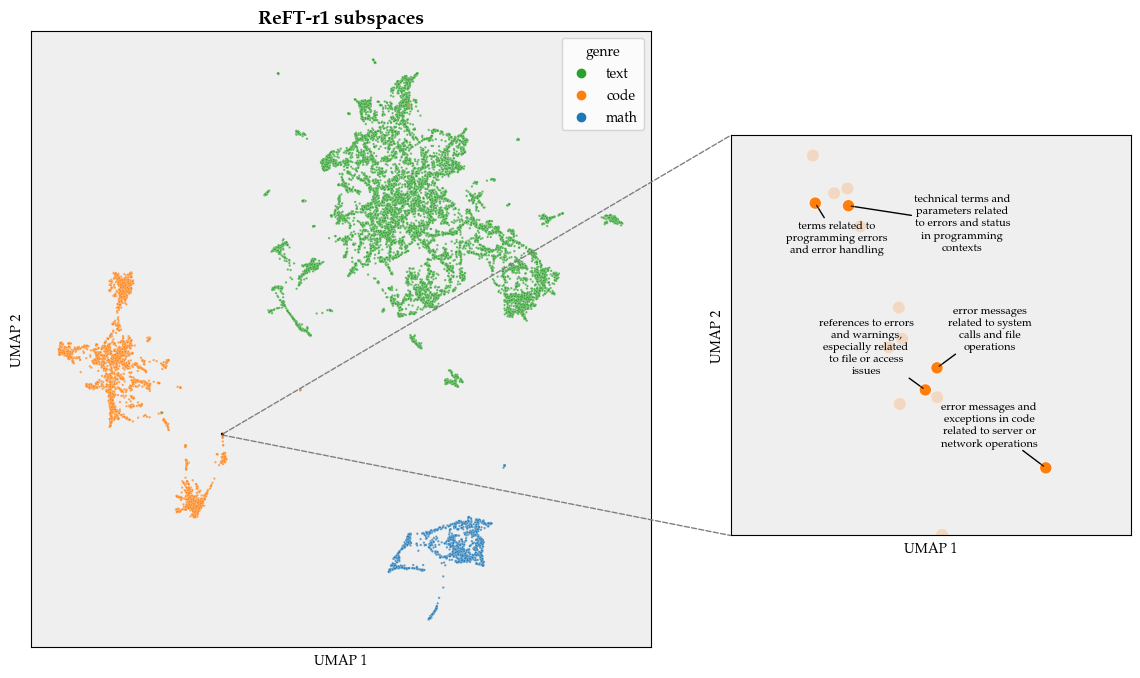

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import textwrap
from adjustText import adjust_text

plt.rcParams['font.family'] = 'P052'

color_map = {
    "math": "#1f77b4",  # Blue
    "code": "#ff7f0e",  # Orange
    "text": "#2ca02c"   # Green
}

# Define inset IDs
inset_ids = {14801, 14404, 5656, 4884, 2467}
df = df_lsreft
inset_df = df_lsreft[df_lsreft["id"].isin(inset_ids)]

# Create the main plot
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot for all points colored by genre
sns.scatterplot(data=df, x="x", y="y", hue="genre", palette=color_map, s=3, alpha=0.7, ax=ax)

# Title and labels
ax.set_title("ReFT-r1 subspaces", fontsize=14, fontweight='bold')
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor("#efefef")

# Define inset bounds in the main plot
x_min, x_max = inset_df["x"].min() - 0.01, inset_df["x"].max() + 0.01
y_min, y_max = inset_df["y"].min() - 0.01, inset_df["y"].max() + 0.01
inset_df_unlabelled = df[(df["x"] >= x_min) & (df["x"] <= x_max) & (df["y"] >= y_min) & (df["y"] <= y_max)]

# Draw a rectangle around the inset region in the main plot
rect = patches.Rectangle(
    (x_min, y_min), x_max - x_min, y_max - y_min, 
    linewidth=1.5, edgecolor='black', facecolor='none', linestyle="dashed"
)
ax.add_patch(rect)

# Create an inset for the "code error" cluster, placing it to the right
inset_ax = fig.add_axes([1, 0.25, 0.5, 0.5])  # (x, y, width, height) outside the main plot
inset_ax.set_xlabel("UMAP 1")
inset_ax.set_ylabel("UMAP 2")
inset_ax.set_facecolor("#efefef")

# Scatter plot for inset
sns.scatterplot(data=inset_df, x="x", y="y", hue="genre", palette=color_map, s=80, ax=inset_ax, legend=False)

# Adjust text labels dynamically
texts = []
for _, row in inset_df.iterrows():
    wrapped_text = "\n".join(textwrap.wrap(row["concept"], width=20))  # Wrap text at 10 characters
    text = inset_ax.text(row["x"], row["y"], wrapped_text, fontsize=8, ha='right', color="black")
    texts.append(text)

# Adjust text to prevent overlap
adjust_text(texts, ax=inset_ax, force_text=(100, 100), expand=(2, 2.5), min_arrow_len=0, arrowprops=dict(arrowstyle="-", color='black'))
sns.scatterplot(data=inset_df_unlabelled, x="x", y="y", hue="genre", palette=color_map, s=80, alpha=0.2, ax=inset_ax, legend=False)

# Set inset limits
inset_ax.set_xlim(x_min, x_max)
inset_ax.set_ylim(y_min, y_max)

# Remove inset ticks for clarity
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# Draw connection lines from the inset region to the inset plot
con1 = patches.ConnectionPatch(
    xyA=(x_min, y_min), xyB=(0, 0), coordsA="data", coordsB="axes fraction",
    axesA=ax, axesB=inset_ax, color="grey", linestyle="dashed"
)
con2 = patches.ConnectionPatch(
    xyA=(x_max, y_max), xyB=(0, 1), coordsA="data", coordsB="axes fraction",
    axesA=ax, axesB=inset_ax, color="grey", linestyle="dashed"
)
fig.add_artist(con1)
fig.add_artist(con2)

# Show the plot
plt.savefig("concept16k_umap.pdf", bbox_inches='tight')
plt.show()

In [9]:
alt.data_transformers.disable_max_rows()

chart = (
    alt.Chart(df_lsreft)
    .mark_circle(size=30)
    .encode(
        x=alt.X('x:Q'),
        y=alt.Y('y:Q'),
        color=alt.Color('genre:N', legend=alt.Legend(title="Genre")),
        tooltip=['concept:N', 'method:N', 'genre:N', 'id:N']  # fields that appear on hover
    )
    .interactive()  # Allows panning & zooming
)

chart  # Display in Jupyter

alt.Chart(...)